In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [2]:

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR100('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR100('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)
print(len(train_loader),len(valid_loader))


/home/clayton/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/clayton/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Files already downloaded and verified
Files already downloaded and verified
1250 313


In [3]:
#Standard CNN and NN
class Net(nn.Module):
  def __init__(self,**kwargs):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
    self.dropout=nn.Dropout(kwargs['dropout_rate'])
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(512 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 100)  # Output size should match the number of classes in CIFAR-100

  def forward(self, x):
      x = self.pool(nn.functional.relu(self.conv1(x)))
      x = self.pool(nn.functional.relu(self.conv2(x)))
      x = self.pool(nn.functional.relu(self.conv3(x)))
      x = (nn.functional.relu(self.conv4(x)))
      x = x.view(-1, 512 * 4 * 4)
      x = nn.functional.relu(self.fc1(self.dropout(x)))
      x = nn.functional.relu(self.fc2(self.dropout(x)))
      x = self.fc3(self.dropout(x))
      return x

In [4]:
#Sector-wise dropout layer
class SWDropOut(torch.nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.group_size = int(kwargs['group_size'])
        self.drop_per_group = int(kwargs['drop_per_group'])
        self.scalar = 1/((self.group_size-self.drop_per_group)/self.group_size)
     
    def forward(self, x):
        if self.training:
            scalar_mask = torch.full(x.size(),self.scalar)
            batch,feature = x.size()
            for item in range(batch):
                for i in range(0,feature,self.group_size):
                    masked_count=0
                    while masked_count < self.drop_per_group:
                        index = random.randint(0, self.group_size-1) 
                        if scalar_mask[item][i+index] !=0:
                            scalar_mask[item][i+index]=0
                            masked_count+=1
            x = torch.multiply(x,scalar_mask)
            # print(x)
            return x
        else:
            return x


In [5]:
#Sector-Wise dropout network
class SwNet(nn.Module):
  def __init__(self, **kwargs):
    super(SwNet, self).__init__()
    # self.relu = nn.ReLU(False)
    # self.flatten = nn.Flatten()
    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout1=SWDropOut(group_size=kwargs['group_size'], drop_per_group=kwargs['drop_per_group'])
    self.fc1 = nn.Linear(512 * 4 * 4, 1024)
    self.dropout2=SWDropOut(group_size=kwargs['group_size'], drop_per_group=kwargs['drop_per_group'])
    self.fc2 = nn.Linear(1024, 512)
    self.dropout3=SWDropOut(group_size=kwargs['group_size'], drop_per_group=kwargs['drop_per_group'])
    self.fc3 = nn.Linear(512, 100)  # Output size should match the number of classes in CIFAR-100

  def forward(self, x):
      x = self.pool(nn.functional.relu(self.conv1(x)))
      x = self.pool(nn.functional.relu(self.conv2(x)))
      x = self.pool(nn.functional.relu(self.conv3(x)))
      x = nn.functional.relu(self.conv4(x))
      x = x.view(-1, 512 * 4 * 4)
      x = nn.functional.relu(self.fc1(self.dropout1(x)))
      x =nn.functional.relu(self.fc2(self.dropout2(x)))
      x = self.fc3(self.dropout3(x))
      return x

In [6]:
def train(model,optim,criterion,train_loader):
    train_loss=0
    
    for data, target in train_loader:
        if train_on_gpu:
            data,target = data.cuda(), target.cuda()
        
        optim.zero_grad()
        output= model(data)
        loss = criterion(output,target)
        loss.backward()
        optim.step()
        
        train_loss+=loss.item()
    
    return train_loss/len(train_loader)

def validate(model,criterion,valid_loader):
    model.eval()
    valid_loss=0
    
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()
        
    valid_loss = valid_loss/len(valid_loader)
    
    return valid_loss

def predict(model,criterion,test_loader):
    model.eval()
    class_correct = list(0. for i in range(100))
    class_total = list(0. for i in range(100))
    test_loss=0
    for data, target in test_loader:
        if train_on_gpu:
            data,target = data.cuda(), target.cuda()
        
        prediction = model(data)
        test_loss += criterion(prediction, target)
    
        _, pred = torch.max(prediction, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        
        for i in range(len(data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    
    test_loss = test_loss/len(test_loader.dataset)
    print(len(test_loader.dataset),len(test_loader))
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    for i in range(100):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                i, 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (i))
    
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    return class_correct,test_loss

In [11]:
def train_and_test_dropout(model,training,validation,testing,epochs):
    optimizer = optim.Adamax(model.parameters(), lr=.001)
    loss_fn = nn.CrossEntropyLoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        print(i)
        loss = train(model,optimizer,loss_fn,training)
        valid_loss = validate(model,loss_fn,validation)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred_totals,test_loss = predict(model,loss_fn,testing)
    
    return train_loss,val_loss,test_loss,y_pred_totals

In [8]:
def makeGraphs_2(do_loss, do_val_loss,do_y_hat,sw_loss, sw_val_loss,sw_y_hat,epochs):
    fig, ((ax11,ax21),(ax12,ax22)) = plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    # ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    # x_temp=[-.25,5.5]
    # y_temp=[-0.25,5.5]
    ax12.bar(range(100),do_y_hat)
    # ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    # ax12.set_ylim(-.25,5.5)
    # ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Inverse Group Based DropOut')
    ax21.plot(epochs,sw_loss,'bo',label='Training Loss')
    ax21.plot(epochs,sw_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    # ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.bar(range(100),sw_y_hat)
    # ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    # ax22.set_ylim(-.25,5.5)
    # ax22.set_xlim(-.25,5.5)
    plt.show()

In [ ]:
epochs=range(25)

dropout_rate=0.5
group_size=2
drop_per_group=1

SW_model = SwNet(group_size=group_size,drop_per_group=drop_per_group)
do_model = Net(dropout_rate=dropout_rate)

sw_t_loss,sw_v_loss,sw_tst_loss,sw_correct_class_totals = train_and_test_dropout(SW_model,train_loader,valid_loader,test_loader,epochs)
print("Sector-Wise Loss: ",sw_tst_loss)
do_t_loss,do_v_loss,do_tst_loss,do_correct_class_totals = train_and_test_dropout(SW_model,train_loader,valid_loader,test_loader,epochs)

print("Dropout Loss: ",do_tst_loss)
makeGraphs_2(do_t_loss,do_v_loss,do_correct_class_totals,sw_t_loss,sw_v_loss,sw_correct_class_totals, epochs)

0


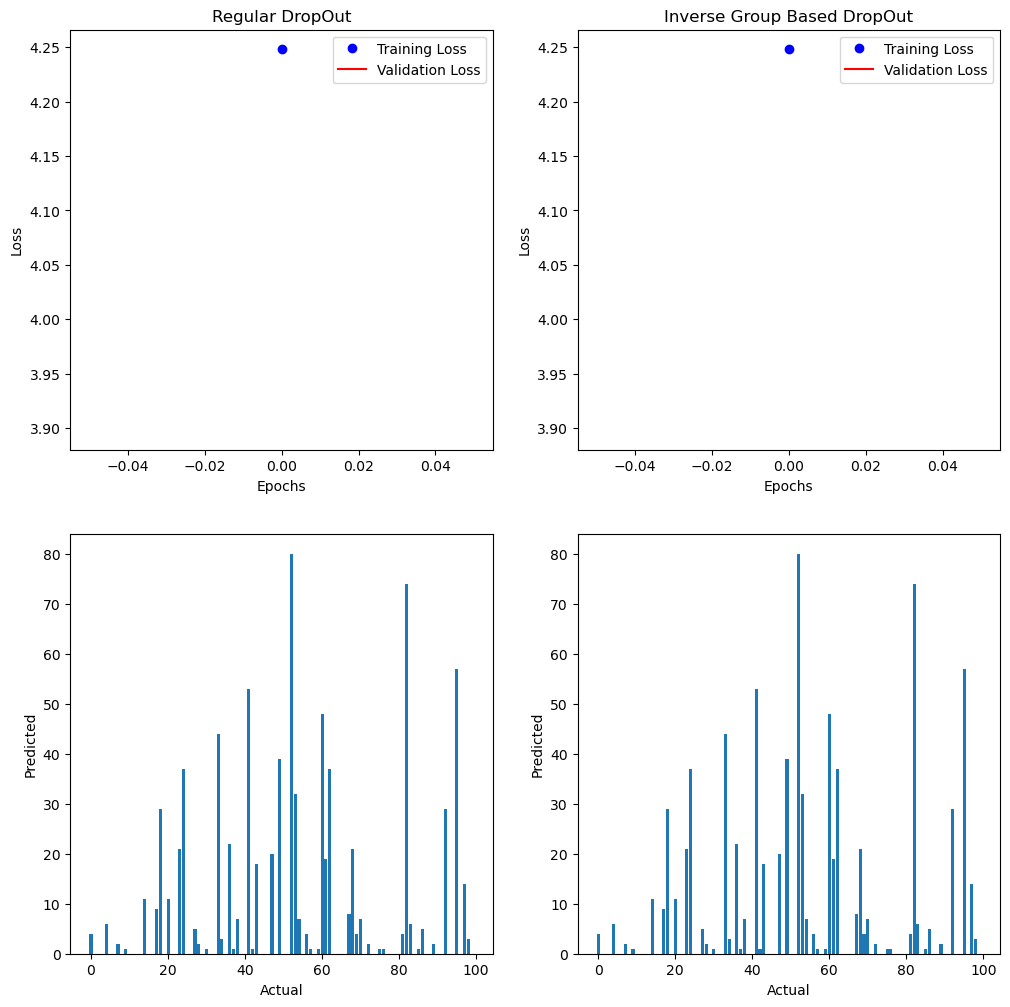

[4.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 9.0, 29.0, 0.0, 11.0, 0.0, 0.0, 21.0, 37.0, 0.0, 0.0, 5.0, 2.0, 0.0, 1.0, 0.0, 0.0, 44.0, 3.0, 0.0, 22.0, 1.0, 7.0, 0.0, 0.0, 53.0, 1.0, 18.0, 0.0, 0.0, 0.0, 20.0, 0.0, 39.0, 0.0, 0.0, 80.0, 32.0, 7.0, 0.0, 4.0, 1.0, 0.0, 1.0, 48.0, 19.0, 37.0, 0.0, 0.0, 0.0, 0.0, 8.0, 21.0, 4.0, 7.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 4.0, 74.0, 6.0, 0.0, 1.0, 5.0, 0.0, 0.0, 2.0, 0.0, 0.0, 29.0, 0.0, 0.0, 57.0, 0.0, 14.0, 3.0, 0.0]


In [10]:
makeGraphs_2(sw_t_loss,sw_v_loss,sw_correct_class_totals,sw_t_loss,sw_v_loss,sw_correct_class_totals, epochs)
print(sw_correct_class_totals)